#### Validation fig and table data analysis for manuscript
many ideas and code take from Ben's great work
https://github.com/GeoscienceAustralia/dea-notebooks/blob/BenL/landcover/LCCS%20Validation.ipynb


In [1]:
import geopandas, pandas, numpy as np, glob, matplotlib.pyplot as plt, cartopy
import scipy.spatial.distance, scipy.stats, rasterio

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#### 1. preprocessing

In [2]:
# load in datasets for 2010 and 2015
def gather(year):
    pattern = '/home/jovyan/development/chris_leaust_testing/manuscript/validation/' + year + '_cleaned_data/validation_*.shp'
    return pandas.concat([geopandas.read_file(filename) for filename in glob.glob(pattern)], ignore_index=True)
before = gather('2010')
after = gather('2015')

# remove any invalid or u (unsure) and m (mixed) validation points
for table in [before, after]:
    criteria = (table.processed != '1') | table[['classified', 'output']].isin(list('um01')).any(axis=1)
    table.drop(table.index[criteria], inplace=True)

# concat both 2010 and 2015 validation points
both = pandas.concat([before, after], ignore_index=True)


In [3]:
# export to shp
# both.to_file('./2010_2015_combined.shp',driver ='ESRI Shapefile')

In [4]:
# fix coordinate jitter (explained in Ben's nb), just makes sure validation points for both years match
before.geometry = geopandas.points_from_xy(before.geometry.x.round(1), before.geometry.y.round(1))

# join datasets
join = pandas.merge(before, after, on='geometry', suffixes=['2010', '2015'])


#### 2. accuracy confusion matrix - users, producers, overall (table for results)
- results of `before` (2010) and `after` (2015) where exported as shp and run through Petes accuracy assessment tool to get error matrices and UA, PA, OA
- also run through https://tool.laco-wiki.net/ to get other stats

In [5]:
# plot confusion matrix 
pandas.pivot_table(after.rename(columns=dict(classified='predicted', output='actual')), 
                   index='predicted', columns='actual', aggfunc='size').fillna(0).astype(int)

actual     111   112  124  215  216  220
predicted                               
111        447   243    2    0    7    0
112         62  2654    1    2  134    1
124          0     2  292    1    2    2
215          0     0    0  281    5    1
216          5   584    2    2  890    1
220          0     2   18    0    2  260

#### 2a. sensitivity, specificity, false discovery
- taken from Bens nb
- good article here https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1#:~:text=Specificity%20and%20sensitivity%20are%20used%20in%20data%20science%20projects%20where,is%20the%20true%20negative%20rate.


In [6]:
def error_stats(year):
    # validation point is correct where classified and output match
    correct = year.classified == year.output
    # TP: true positive, TN: true negative , FP: false positive, FN: false negative
    TP = year[correct].groupby('classified').size()
    FP = year[~correct].groupby('classified').size()
    FN = year[~correct].groupby('output').size()
    TN = len(year) - (TP + FP + FN)
    
    # sensitivity = True Positive Rate; It informs us about the proportion of actual positive cases that have gotten predicted as positive by our classification.
    # specificity = True Negative Rate; It informs us about the proportion of actual negative cases that have gotten predicted as negative by our classification. It is the ratio of true negatives to all negatives
    # false discovery rate (FDR) is the ratio of the number of false positive results to the number of total positive test results. FDR is defined as the expected proportion of false discoveries
    out = pandas.concat([
        (TP / (TP + FN)).rename('sensitivity'),
        (TN / (TN + FP)).rename('specificity'),
        (FP / (TP + FP)).rename('false discovery'),
        (TP / (TP + FP)).rename('producers accuracy'),
        (TP / (TP + FN)).rename('users accuracy')
    ], axis=1).rename_axis('class').round(4) * 100
    return out

error_stats(after)

sensitivity  specificity  false discovery  producers accuracy  \
class                                                                  
111          86.96        95.33            36.05               63.95   
112          76.15        91.74             7.01               92.99   
124          92.70        99.87             2.34               97.66   
215          98.25        99.89             2.09               97.91   
216          85.58        87.79            40.03               59.97   
220          98.11        99.61             7.80               92.20   

       users accuracy  
class                  
111             86.96  
112             76.15  
124             92.70  
215             98.25  
216             85.58  
220             98.11

#### 3. spatial accuracy maps (fig for results)

really like this example from DEAfrica, also Ben has examples in initial nb

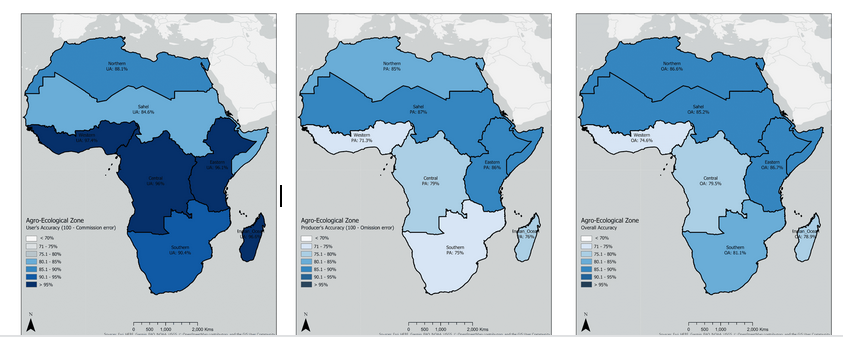

for disaggregation of OA, UA, PA
- try koppen climate major groups
- try bioregions
- try states
- do for 2010, 2015, combined


In [7]:
with rasterio.open('./Beck_KG_V1_present_0p0083.tif') as f:
    mapextent = both.to_crs(f.crs).total_bounds
    minimap = f.read(1, window=rasterio.windows.from_bounds(*mapextent, transform=f.transform))
    
    for table in [join, both]:
        pts = table.geometry.to_crs(f.crs)
        table['region'] = [x[0] for x in rasterio.sample.sample_gen(f, zip(pts.x, pts.y))]

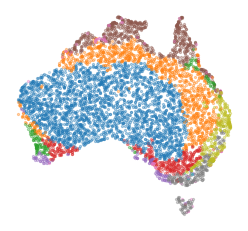

In [8]:
for i in both.region.unique():
    both.query('region==' + str(i)).plot(alpha=0.2, ax=plt.gca(), markersize=5)
plt.gca().axis("off"); None

In [9]:
maplegend = pandas.read_fwf('./Beck_KG_V1_present_0p0083_legend.txt', 
                            skiprows=3, skipfooter=7, index_col=0,
                            names=[None, 'code', 'description'], colspecs=[(4,7), (8,11), (13, 51)])
maplegend.index = maplegend.index.str[:-1].astype(int)

In [ ]:
''' testing '''
# where output is 111 but classified as =! 111 append to column
regional['as 111'] = (both[correct].groupby('region').size() / regional.samples).round(3) * 100

# where
def error_stats(year):
    # validation point is correct where classified and output match
    correct = year.classified == year.output
    # TP: true positive, TN: true negative , FP: false positive, FN: false negative
    TP = year[correct].groupby('classified').size()
    FP = year[~correct].groupby('classified').size()
    FN = year[~correct].groupby('output').size()
    TN = len(year) - (TP + FP + FN)
    
    # sensitivity = True Positive Rate; It informs us about the proportion of actual positive cases that have gotten predicted as positive by our classification.
    # specificity = True Negative Rate; It informs us about the proportion of actual negative cases that have gotten predicted as negative by our classification. It is the ratio of true negatives to all negatives
    # false discovery rate (FDR) is the ratio of the number of false positive results to the number of total positive test results. FDR is defined as the expected proportion of false discoveries
    out = pandas.concat([
        (TP / (TP + FN)).rename('sensitivity'),
        (TN / (TN + FP)).rename('specificity'),
        (FP / (TP + FP)).rename('false discovery'),
        (TP / (TP + FP)).rename('producers accuracy'),
        (TP / (TP + FN)).rename('users accuracy')
    ], axis=1).rename_axis('class').round(4) * 100
    return out

error_stats(after)

In [111]:
correct = both.classified == both.output

# TP: true positive, TN: true negative , FP: false positive, FN: false negative
regional = both.groupby((['region', 'classified'])).size().rename('samples').to_frame()
regional['TP'] = both[correct].groupby((['region', 'classified'])).size()
regional['FP'] = both[~correct].groupby((['region', 'classified'])).size()
regional['FN'] = both[~correct].groupby((['region', 'output'])).size()
regional['PA'] = (regional['TP'] / (regional['TP'] + regional['FP']))
regional['UA'] = (regional['TP'] / (regional['TP'] + regional['FN']))


region = both.groupby('region').size().rename('samples').to_frame()
region['UA'] = regional.UA.groupby(['region']).mean().round(3) * 100
region['PA'] = regional.PA.groupby(['region']).mean().round(3) * 100
region['OA'] = (both[correct].groupby('region').size() / region.samples).round(3) * 100

# regional['UA'] = (both[correct].groupby('region').size() / regional.samples).round(3) * 100

# regional.sort_values('samples', ascending=False).join(maplegend)\
#   .rename(columns={'accuracy':'accuracy (%)', 'code':'region'}).set_index('region')
# regional['test'] = both[correct].groupby(['region', 'classified']).size()



# region = both.groupby('region').size().rename('samples').to_frame()
# regional['accuracy'] = (both[correct].groupby('region').size() / regional.samples).round(3) * 100

region.sort_values('samples', ascending=False).join(maplegend)\
  .rename(columns={'accuracy':'accuracy (%)', 'code':'region'}).set_index('region')

samples    UA    PA     OA                            description
region                                                                   
BWh        4825  79.3  69.5   68.3                      Arid, desert, hot
BSh        2176  77.4  76.2   88.1                      Arid, steppe, hot
Aw         1383  86.2  71.6   95.9                     Tropical, savannah
BSk         973  74.5  75.2   80.7                     Arid, steppe, cold
Cfa         635  77.3  69.8   84.6   Temperate, no dry season, hot summer
Cfb         591  83.9  81.3   85.8  Temperate, no dry season, warm summer
BWk         381  80.0  61.1   78.0                     Arid, desert, cold
Csa         245  81.2  76.0   84.9      Temperate, dry summer, hot summer
Csb         232  74.9  73.5   84.5     Temperate, dry summer, warm summer
NaN         149  84.9  77.0   96.6                                    NaN
Cwa         100  97.7  66.7   98.0      Temperate, dry winter, hot summer
Am           30  50.0  66.5   80.0                      Tropical, monsoon
Af            6   NaN  50.0   83.3                   Tropical, rainforest
Dfc           4  50.0   NaN   50.0       Cold, no dry season, cold summer
ET            3   NaN   NaN  100.0                          Polar, tundra
Cfc           2   NaN   NaN  100.0  Temperate, no dry season, cold summer
Dfb           2   NaN   NaN  100.0       Cold, no dry season, warm summer

#### 4. validator comparison (table in supp data)

In [15]:
# load comparison data
pattern = '/home/jovyan/development/chris_leaust_testing/manuscript/validation/validator_comparison_completed/validation_comparison_*.shp'
filenames = sorted(glob.glob(pattern))
names = [filename.split('_')[-1][:-4] for filename in filenames]
subtables = [geopandas.read_file(filename) for filename in filenames]
comparison = pandas.concat([subtables[0].classified] + 
                     [df.output.rename(name) for name, df in zip(names, subtables)], axis=1)

# comparison table between validation team members (% agreement)
dist = scipy.spatial.distance.pdist(comparison.replace(['m', 'u'], [0, 1]).values.T, 'jaccard')
dist = scipy.spatial.distance.squareform(dist)
dist = pandas.DataFrame((1-dist) * 100, columns=comparison.columns, index=comparison.columns)

dist.round(3).style.background_gradient(cmap='cividis_r', axis=None).set_precision(0)